# Using Spark EMR Clusters in SageMaker with R Kernel

<hr>


The purpose of this notebook is to demonstrate how SageMaker notebook with R kernel can be connected to an EMR cluster using `SparklyR` package. The notebook uses `iris`, `abalone`, and `mtcars` public datasets to demonstrate this connection.

Before using this notebook, you need to establish the VPC and Security Groups for the EMR cluster and your SageMaker notebook to ensure seamless connection. Please follow the steps outlines in the README.md file.

## Table of Contents:
- [Background](#Background)
- [Connection to EMR Cluster](#Connection-to-EMR-Cluster)
- [Import Datasets and Write to EMR Cluster](#Import-Datasets)
- [Data Exploration and Visualiztion](#Data-Exploration-and-Visualiztion)
- [Using SQL to Query Data from EMR Cluster](#Using-SQL)
- [Machine Learning on EMR Cluster using Spark](#Machine-Learning)
- [Reading and Writing CSV, JSON and Parquet Data to EMR Cluster](#Reading-and-Writing-CSV,-JSON-and-Parquet-Data-to-EMR-Cluster)
- [Disconnect the EMR Connection](#Disconnect-the-EMR-Connection)


## Background
#### SparklyR:

The [Sparklyr](https://spark.rstudio.com/) package by RStudio makes big data processing capabilities in R a lot easier by providing an R interface to [Apache Spark](https://spark.apache.org/). According to the documentation, `SparklyR` can:
> - Connect to Spark from R. The sparklyr package provides a complete [dplyr](https://github.com/hadley/dplyr) backend.
> - Filter and aggregate Spark datasets then bring them into R for analysis and visualization.
> - Use Spark’s distributed [machine learning](http://spark.apache.org/docs/latest/mllib-guide.html) library from R.
> - Create [extensions](http://spark.rstudio.com/extensions.html) that call the full Spark API and provide interfaces to Spark packages.

#### Amazon EMR:
Amazon EMR is a popular hosted big data processing service on AWS. EMR provides the latest version of Spark and other Hadoop ecosystem applications such as Apache Spark, Apache Hive, Apache HBase, as well as Hue, Sqoop, Tez, Zeppeling, TensorFlow, and Presto. [Amazon EMR](https://aws.amazon.com/emr/) mentions:
> Amazon EMR is the industry-leading cloud big data platform for processing vast amounts of data using open source tools such as Apache Spark, Apache Hive, Apache HBase, Apache Flink, Apache Hudi, and Presto. With EMR you can run Petabyte-scale analysis at less than half of the cost of traditional on-premises solutions and over 3x faster than standard Apache Spark. For short-running jobs, you can spin up and spin down clusters and pay per second for the instances used. For long-running workloads, you can create highly available clusters that automatically scale to meet demand. If you have existing on-premises deployments of open source tools such as Apache Spark and Apache Hive, you can also run EMR clusters on AWS Outposts.

#### Apache Livy:
[Apache Livy](https://livy.apache.org/) is a REST Service for Apache Spark that allows submission of jobs to Spark clusters from anywhere using REST interfaces. The documentation mentions:
> Apache Livy enables easy interaction with a Spark cluster over a REST interface. It enables easy submission of Spark jobs or snippets of Spark code, synchronous or asynchronous result retrieval, as well as Spark Context management, all via a simple REST interface or an RPC client library. 

## Connection to EMR Cluster
Before running the code in this notebook, you should follow the steps in the README.md file to allow the connection to the EMR cluster through port 8998 (livy). We will use `spark_connect` with `livy` to connect to the EMR cluster through this port.

In [1]:
# Switching warnings off
options(warn=-1)

In [2]:
# Install sparklyr package
suppressMessages(install.packages("sparklyr"))
library(sparklyr)

In [3]:
# Master public DNS
# Replace this with the EMR public DNS from EMR details
emr_dns <- 'REPLACE THIS WITH YOUR EMR MASTER PUBLIC DNS'
master_port <- paste(emr_dns,':8998',sep = '')
master_port

[1] "ec2-100-26-111-163.compute-1.amazonaws.com:8998"

In [4]:
# Establish Connetion with EMR cluster's mater instance through port 8998 using livy method
sc <- spark_connect(master = master_port, 
            method = 'livy', 
            version ='2.4.4',
            spark_home = Sys.getenv("SPARK_HOME"),
            app_name = "sparklyr")

In [5]:
# Check if connection is established
spark_connection_is_open(sc)

[1] TRUE

## Import Datasets

In [6]:
# Import dplyr and readr library
library(dplyr, warn.conflicts = FALSE)
library(readr)

In [7]:
# Import abalone dataset from UCI 
cols <- c('sex', 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight', 'rings')
data_file <- 'http://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data'
abalone <- read_csv(file = data_file, col_names = cols)
head(abalone)

Parsed with column specification:
cols(
  sex = col_character(),
  length = col_double(),
  diameter = col_double(),
  height = col_double(),
  whole_weight = col_double(),
  shucked_weight = col_double(),
  viscera_weight = col_double(),
  shell_weight = col_double(),
  rings = col_double()
)


sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7
I,0.425,0.300,0.095,0.3515,0.1410,0.0775,0.120,8


In [8]:
# Import dplyr library
library(dplyr, warn.conflicts = FALSE)

In [9]:
# import and check iris dataset
library(datasets)
data(iris)
head(iris)

Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
5.1,3.5,1.4,0.2,setosa
4.9,3.0,1.4,0.2,setosa
4.7,3.2,1.3,0.2,setosa
4.6,3.1,1.5,0.2,setosa
5.0,3.6,1.4,0.2,setosa
5.4,3.9,1.7,0.4,setosa


In [10]:
# Send the dataset to the EMR cluster
iris_tbl <- copy_to(sc, iris, overwrite = TRUE)
abalone_tbl <- copy_to(sc, abalone, overwrite = TRUE)

# check the tables on the cluster
# output should be 'abalone' 'iris'
src_tbls(sc)

[1] "abalone" "iris"

In [11]:
# Show the abalone table within the cluster
abalone_tbl

# Source: spark<abalone> [?? x 9]
   sex   length diameter height whole_weight shucked_weight viscera_weight
   <chr>  <dbl>    <dbl>  <dbl>        <dbl>          <dbl>          <dbl>
 1 M      0.455    0.365  0.095        0.514         0.224          0.101 
 2 M      0.35     0.265  0.09         0.226         0.0995         0.0485
 3 F      0.53     0.42   0.135        0.677         0.256          0.142 
 4 M      0.44     0.365  0.125        0.516         0.216          0.114 
 5 I      0.33     0.255  0.08         0.205         0.0895         0.0395
 6 I      0.425    0.3    0.095        0.352         0.141          0.0775
 7 F      0.53     0.415  0.15         0.778         0.237          0.142 
 8 F      0.545    0.425  0.125        0.768         0.294          0.150 
 9 M      0.475    0.37   0.125        0.509         0.216          0.112 
10 F      0.55     0.44   0.15         0.894         0.314          0.151 
# … with more rows, and 2 more variables: shell_weight <dbl>, ring

In [12]:
# Show the iris table, use the table within the cluster
iris_tbl

# Source: spark<iris> [?? x 5]
   Sepal_Length Sepal_Width Petal_Length Petal_Width Species
          <dbl>       <dbl>        <dbl>       <dbl> <chr>  
 1          5.1         3.5          1.4         0.2 setosa 
 2          4.9         3            1.4         0.2 setosa 
 3          4.7         3.2          1.3         0.2 setosa 
 4          4.6         3.1          1.5         0.2 setosa 
 5          5           3.6          1.4         0.2 setosa 
 6          5.4         3.9          1.7         0.4 setosa 
 7          4.6         3.4          1.4         0.3 setosa 
 8          5           3.4          1.5         0.2 setosa 
 9          4.4         2.9          1.4         0.2 setosa 
10          4.9         3.1          1.5         0.1 setosa 
# … with more rows

In [13]:
# filter the abalone table within the cluster by Sex=="M", use the table within the cluster
abalone_tbl %>% filter(sex == 'M')

# Source: spark<?> [?? x 9]
   sex   length diameter height whole_weight shucked_weight viscera_weight
   <chr>  <dbl>    <dbl>  <dbl>        <dbl>          <dbl>          <dbl>
 1 M      0.455    0.365  0.095        0.514         0.224          0.101 
 2 M      0.35     0.265  0.09         0.226         0.0995         0.0485
 3 M      0.44     0.365  0.125        0.516         0.216          0.114 
 4 M      0.475    0.37   0.125        0.509         0.216          0.112 
 5 M      0.43     0.35   0.11         0.406         0.168          0.081 
 6 M      0.49     0.38   0.135        0.542         0.218          0.095 
 7 M      0.5      0.4    0.13         0.664         0.258          0.133 
 8 M      0.365    0.295  0.08         0.256         0.097          0.043 
 9 M      0.45     0.32   0.1          0.381         0.170          0.075 
10 M      0.355    0.28   0.095        0.246         0.0955         0.062 
# … with more rows, and 2 more variables: shell_weight <dbl>, rings <dbl

## Data Exploration and Visualiztion
In this sections of this notebook, `abalone` dataset on the EMR cluster will be used.

In [14]:
# Creating a summary table called abalones using the table within the cluster
abalones <- abalone_tbl %>%
  group_by(sex)%>%
  summarise(avg_len = mean(length), 
            avg_dia = mean(diameter),
           avg_ht = mean(height),
           avg_w_wgt = mean(whole_weight),
           avg_shk_wgt = mean(shucked_weight),
           avg_vsc_wgt = mean(shucked_weight)) %>% collect
  
head(abalones)

sex,avg_len,avg_dia,avg_ht,avg_w_wgt,avg_shk_wgt,avg_vsc_wgt
F,0.5790933,0.4547322,0.1580107,1.0465321,0.4461878,0.4461878
M,0.5613907,0.4392866,0.1513809,0.9914594,0.4329460,0.4329460
I,0.4277459,0.3264940,0.1079955,0.4313625,0.1910350,0.1910350


Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


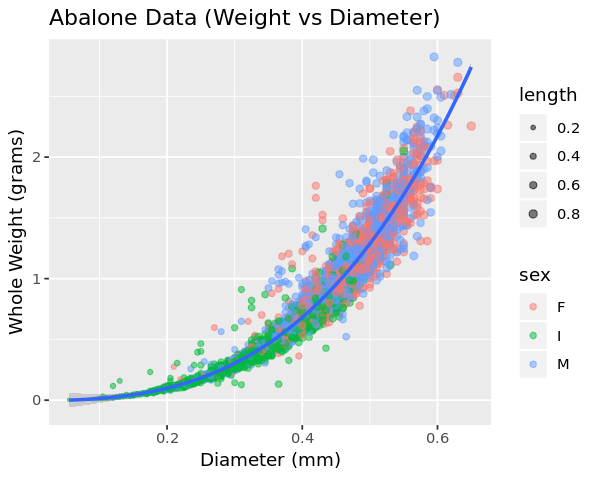

In [15]:
# plot abalone table within the cluster
library(ggplot2)

# Set the size of the plot
options(repr.plot.width = 5, repr.plot.height = 4) 

# plot the data
ggplot(abalone_tbl, aes(diameter, whole_weight)) +
    geom_point(aes(size = length, color=sex), alpha = 1/2) +
    geom_smooth(method = lm, formula = y ~ poly(x,3)) +
    scale_size_area(max_size = 2) +
    xlab('Diameter (mm)') +
    ylab('Whole Weight (grams)') +
    ggtitle('Abalone Data (Weight vs Diameter)')

## Using SQL
The spark_connection object implements a `DBI` interface for Spark and `dbGetQuery` can be used to execute SQL and return the result as an R data frame. Let's query some data from the `abalone` table on the cluster.

In [16]:
# import DBI library for executing SQL query
library(DBI)

# Get data from the cluster using SQL
abalone_preview <- dbGetQuery(sc, "SELECT * FROM abalone LIMIT 10")
abalone_preview

sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7
I,0.425,0.300,0.095,0.3515,0.1410,0.0775,0.120,8
F,0.530,0.415,0.150,0.7775,0.2370,0.1415,0.330,20
F,0.545,0.425,0.125,0.7680,0.2940,0.1495,0.260,16
M,0.475,0.370,0.125,0.5095,0.2165,0.1125,0.165,9
F,0.550,0.440,0.150,0.8945,0.3145,0.1510,0.320,19


## Machine Learning
You can build and train machine learning algorithms in a Spark cluster via the machine learning functions within sparklyr that connect to a set of high-level APIs built on top of DataFrames.

This section outlines an example from [SparklyR Documentation](https://spark.rstudio.com/) where  [Linear Regression](https://spark.rstudio.com/reference/ml_linear_regression/) is used with the built-in `mtcars` dataset to predict a car’s fuel consumption (mpg) based on weight (wt), and the number of cylinders the engine contains (cyl).

In [17]:
# Code from https://spark.rstudio.com/

# copy mtcars into spark
mtcars_tbl <- copy_to(sc, mtcars)

# transform our data set, and then partition into 'training', 'test'
partitions <- mtcars_tbl %>%
  filter(hp >= 100) %>%
  mutate(cyl8 = cyl == 8) %>%
  sdf_partition(training = 0.5, test = 0.5, seed = 1099)

# fit a linear model to the training dataset
fit <- partitions$training %>%
  ml_linear_regression(response = "mpg", features = c("wt", "cyl"))
fit

Formula: mpg ~ wt + cyl

Coefficients:
(Intercept)          wt         cyl 
  33.499452   -2.818463   -0.923187 

Let's use `summary()` to get more details about the linear regression models produced by Spark.

In [18]:
summary(fit)

Deviance Residuals:
   Min     1Q Median     3Q    Max 
-1.752 -1.134 -0.499  1.296  2.282 

Coefficients:
(Intercept)          wt         cyl 
  33.499452   -2.818463   -0.923187 

R-Squared: 0.8274
Root Mean Squared Error: 1.422


## Reading and Writing CSV, JSON and Parquet Data to EMR Cluster
Data can be read and written in CSV, JSON, and Parquet formats. Also, data can be stored in HDFS, S3, or on the local filesystem of cluster nodes. In this section, we create 3 different formats of the iris dataset, and write them to the cluster.

In [19]:
# Code from https://spark.rstudio.com/

# Create blank temp files in three formats
temp_csv <- tempfile(fileext = ".csv")
temp_parquet <- tempfile(fileext = ".parquet")
temp_json <- tempfile(fileext = ".json")

# write iris_table from the cluster to these blank temp files on the cluster then read them using spark
spark_write_csv(iris_tbl, temp_csv)
iris_csv_tbl <- spark_read_csv(sc, "iris_csv", temp_csv)

spark_write_parquet(iris_tbl, temp_parquet)
iris_parquet_tbl <- spark_read_parquet(sc, "iris_parquet", temp_parquet)

spark_write_json(iris_tbl, temp_json)
iris_json_tbl <- spark_read_json(sc, "iris_json", temp_json)

# show the tables on the cluter
# Should look like 'abalone' 'iris' 'iris_csv' 'iris_json' 'iris_parquet' 'mtcars'
src_tbls(sc)

[1] "abalone"      "iris"         "iris_csv"     "iris_json"    "iris_parquet"
[6] "mtcars"

## Disconnect the EMR Connection

In [20]:
# disconnect connection with the EMR Cluster
spark_disconnect(sc)

In [21]:
# Check the connection again, it should be "FALSE"
spark_connection_is_open(sc)

[1] FALSE